# Bikes

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb

from vi_evi import vi_evi 

In [2]:
RANDOM_SEED = 8457
rng = np.random.RandomState(RANDOM_SEED)
az.style.use("arviz-white")
plt.rcParams["figure.dpi"] = 300

In [3]:
# We keep every 50th row
bikes = pd.read_csv("bikes_full.csv")[::50]

Y = bikes.pop("count")
# FIXME this should be just X = bikes
X = bikes[["hour", "temperature", "humidity", "season", "feeling_temperature"]]


We perform a first run to get the ranking of the variable importance

In [4]:
with pm.Model() as model:
    α = pm.Exponential("α", 0.1)
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50)
    μ = pm.Deterministic("μ", np.exp(μ_))
    y = pm.NegativeBinomial("y", mu=μ, alpha=α, observed=Y)
    idata = pm.sample(chains=4, random_seed=RANDOM_SEED, compute_convergence_checks=False)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.


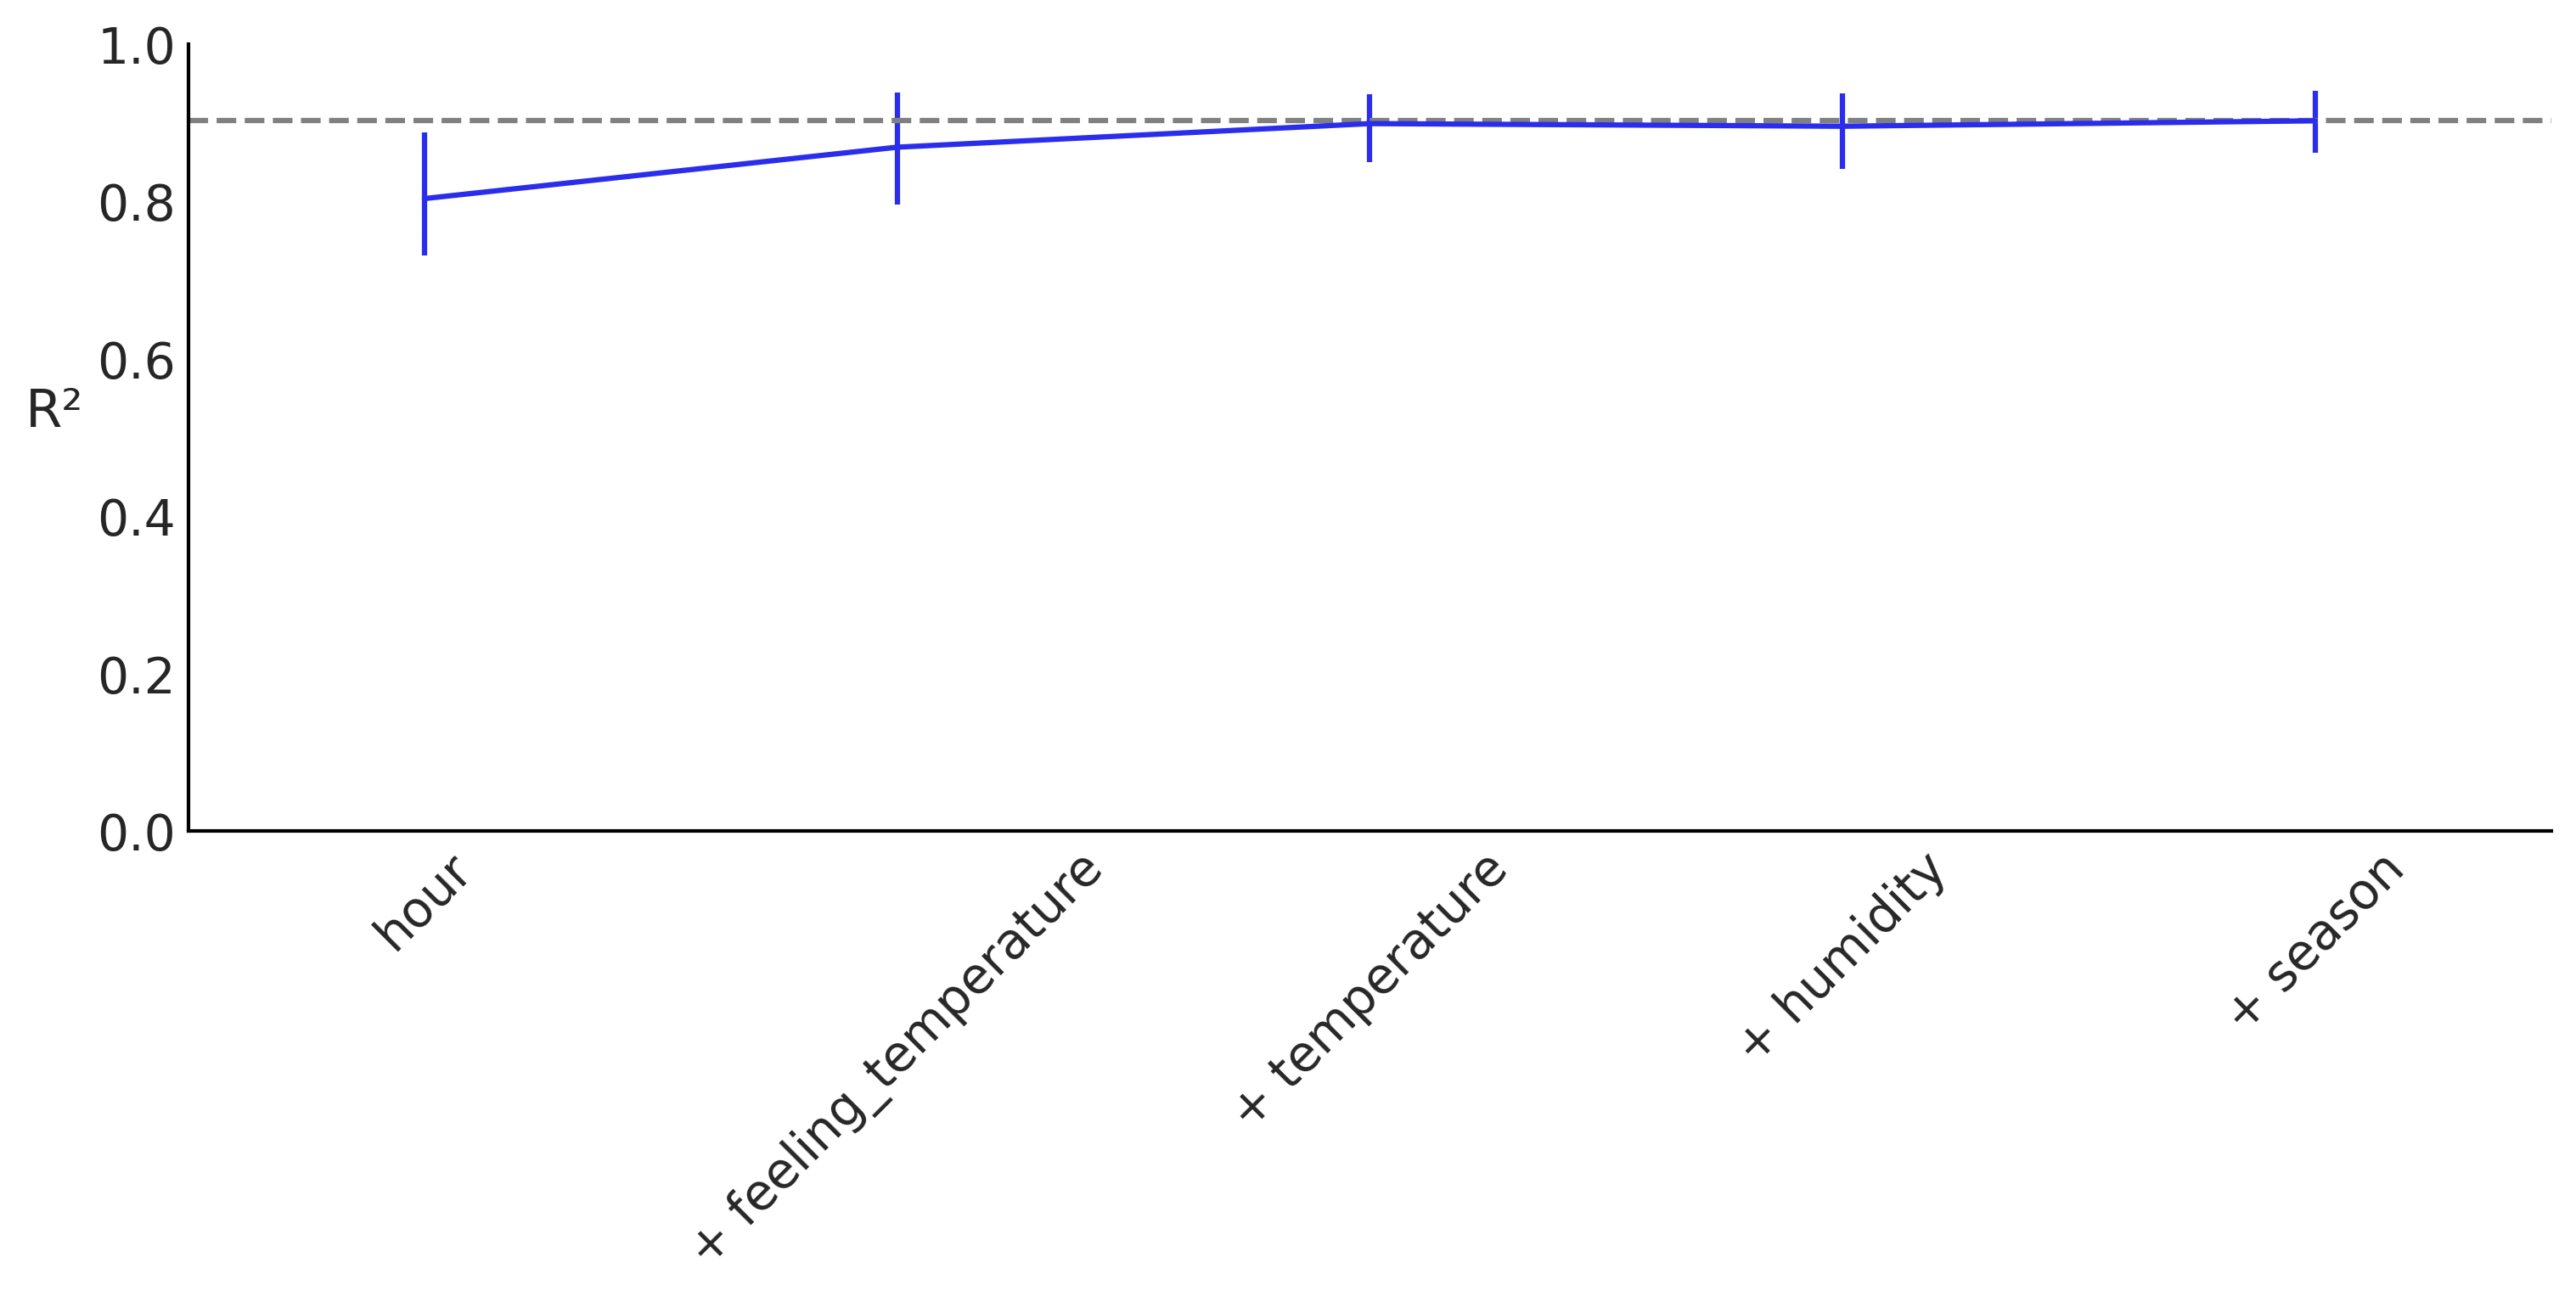

In [5]:
indices_vi, _ = pmb.utils.plot_variable_importance(idata, μ_, X, method="VI", xlabel_angle=45, figsize=(10, 5), random_seed=RANDOM_SEED)

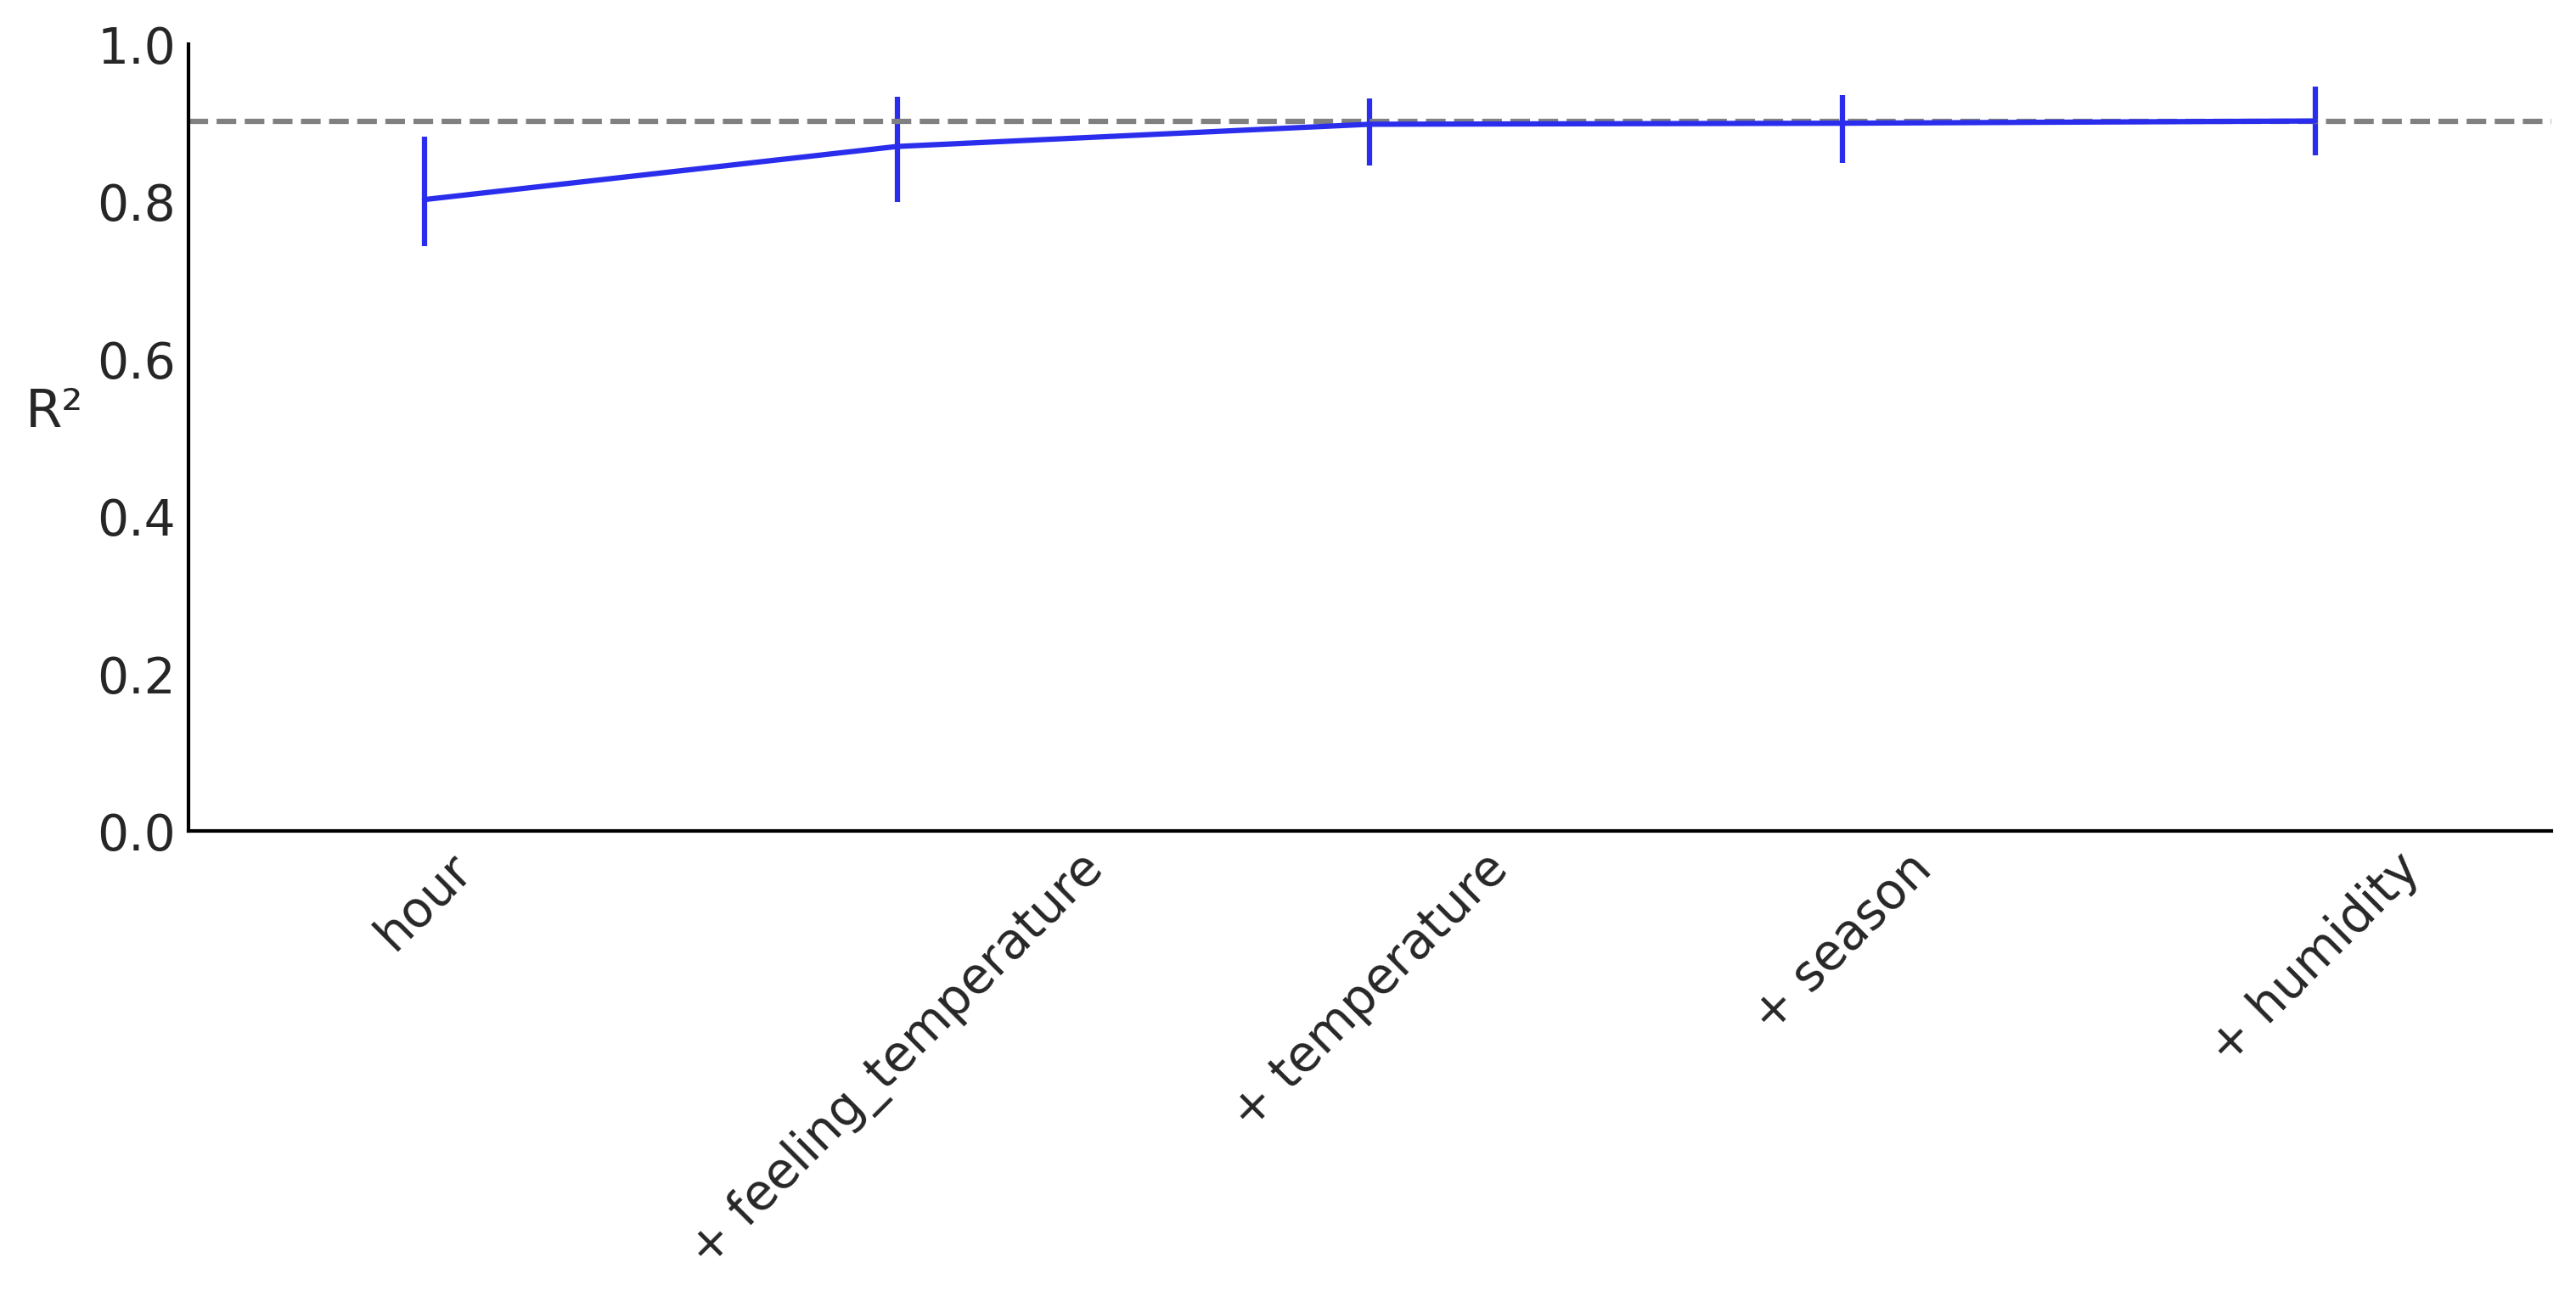

In [6]:
indices_bw, _ = pmb.utils.plot_variable_importance(idata, μ_, X, method="backward", xlabel_angle=45, figsize=(10, 5), random_seed=RANDOM_SEED)

## Explicit computation of R² following method="VI" order, with m=50

In [7]:
idatas = []
bart_rvs = []

for idx in range(X.shape[1]):
    with pm.Model() as model:
        α = pm.Exponential("α", 0.1)
        μ_ = pmb.BART("μ_", X.iloc[:,indices_vi[:idx+1]], np.log(Y), m=50)
        μ = pm.Deterministic("μ", np.exp(μ_))
        y = pm.NegativeBinomial("y", mu=μ, alpha=α, observed=Y)
        idata = pm.sample(chains=4, random_seed=RANDOM_SEED, compute_convergence_checks=False)
        idatas.append(idata)
        bart_rvs.append(μ_)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 77 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.


We now check that computing the predictions estimated by pruning the trees is close to the predictions if we actually ommits covariables and refit models

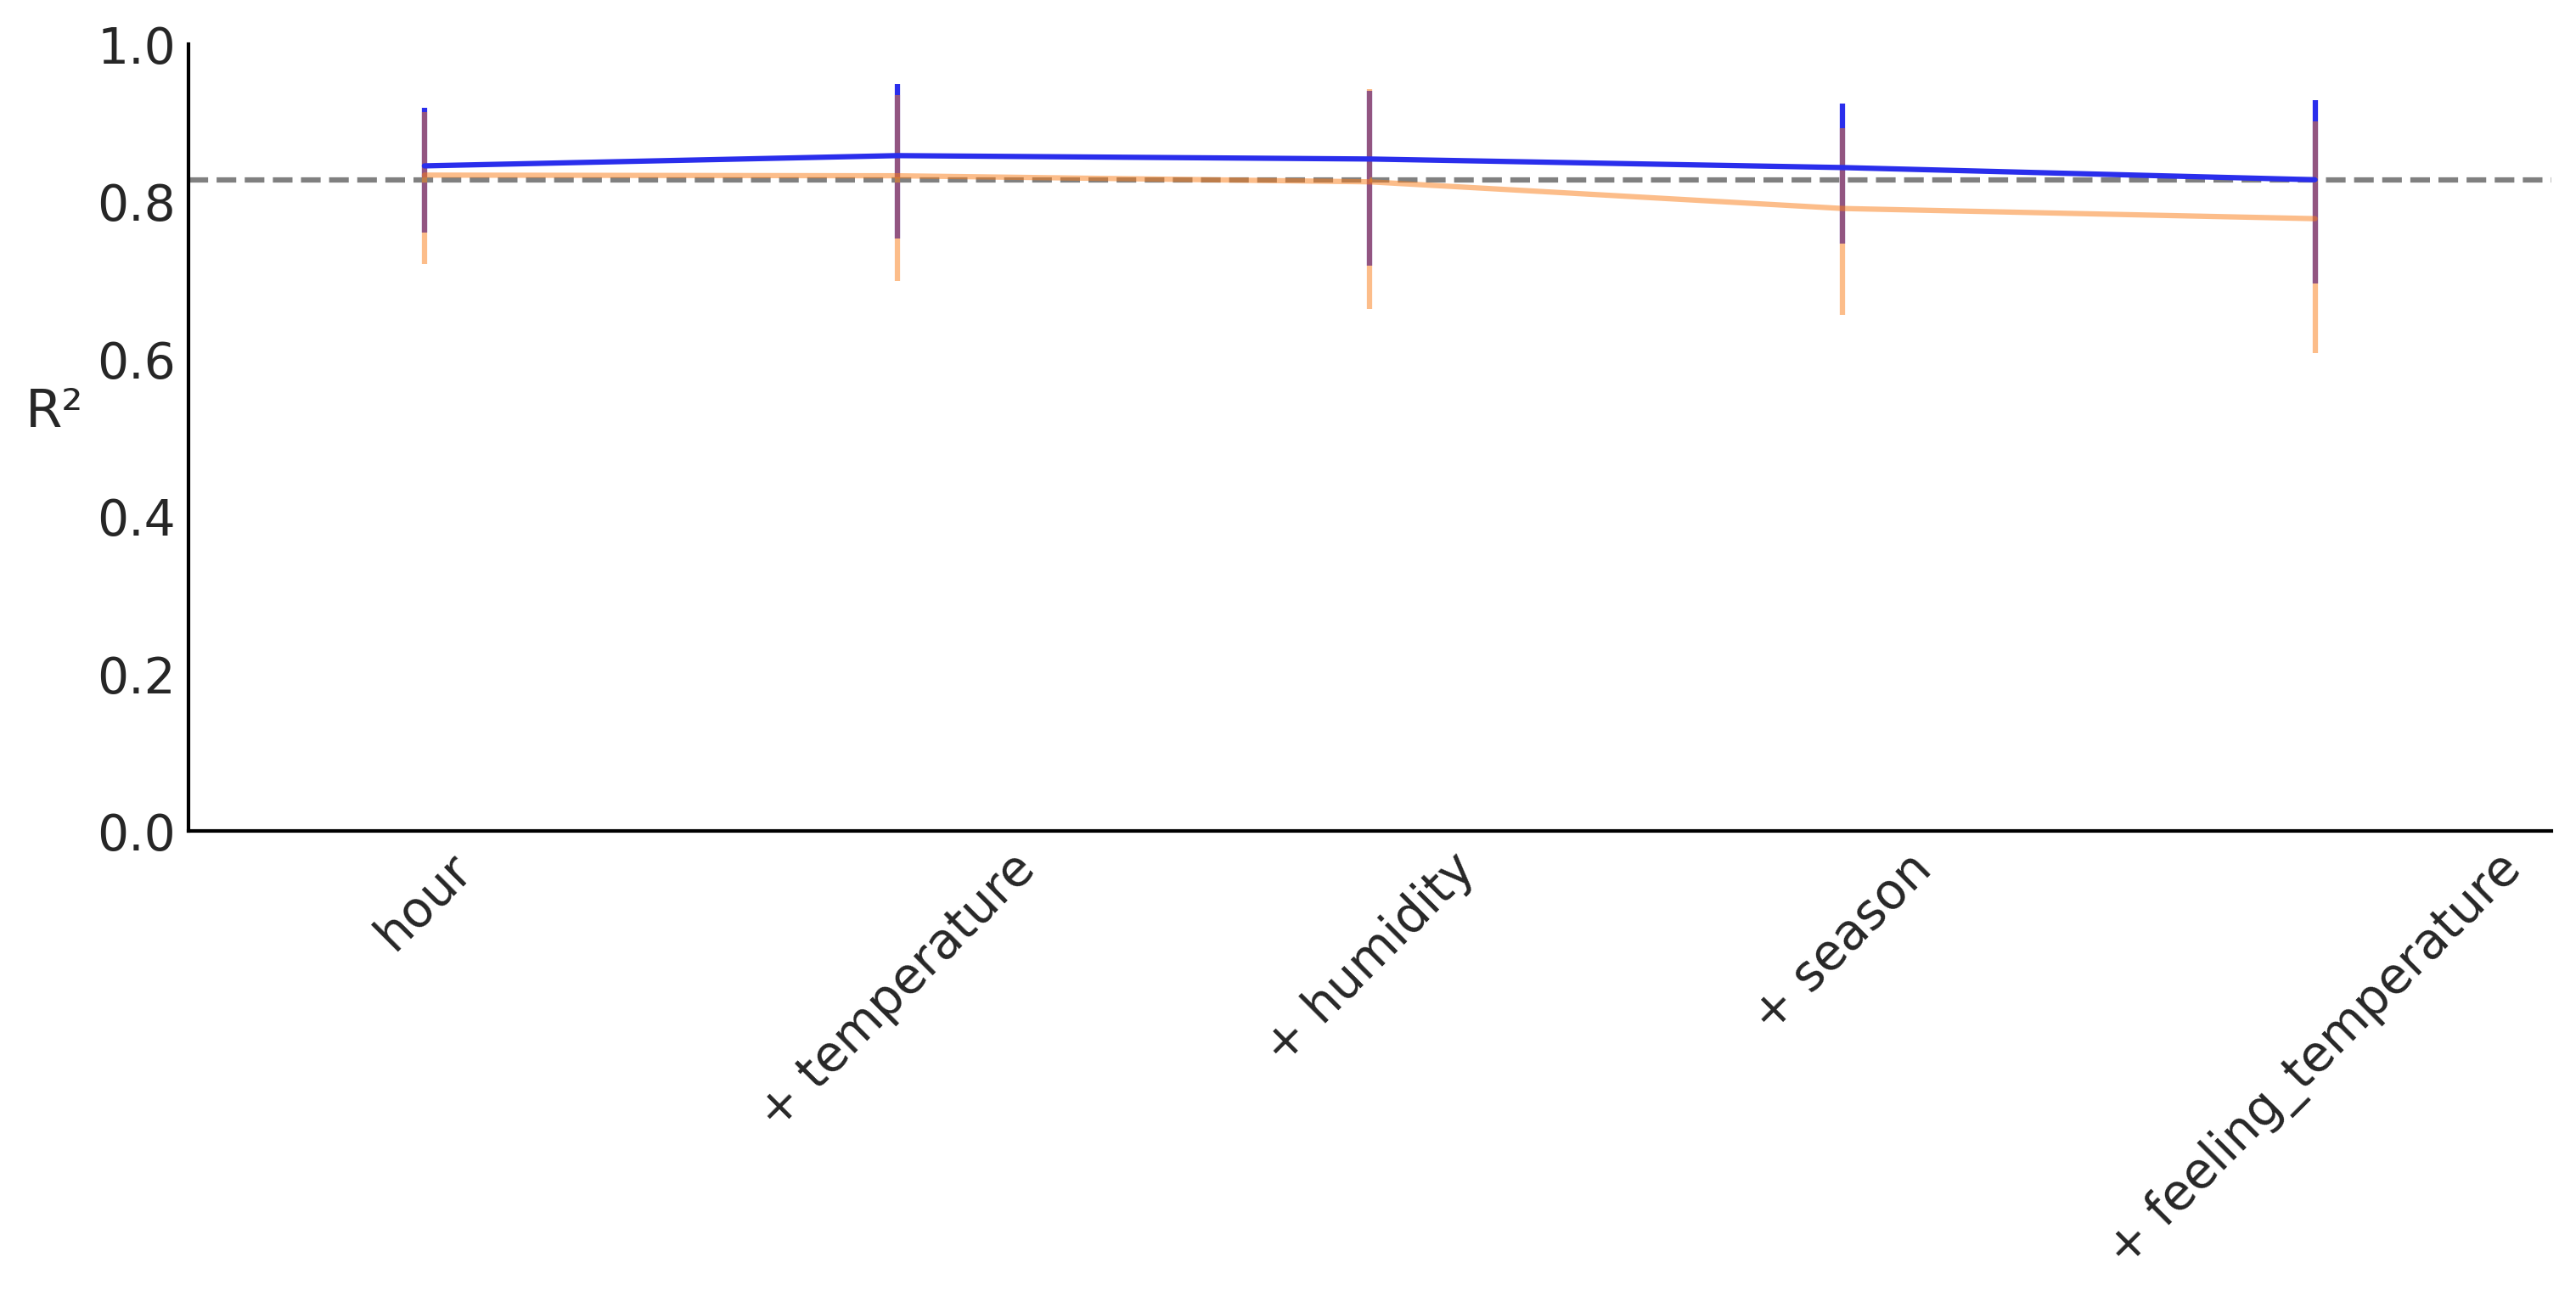

In [8]:
import sys
from importlib import reload
from vi_evi import vi_evi
reload(sys.modules['vi_evi'])
vi_evi(bart_rvs, idatas, X, indices_vi, "VI", 100, RANDOM_SEED, figsize=(10, 5))
plt.savefig(f"bikes_m50_vi_small.png")

In [9]:
daf

NameError: name 'daf' is not defined

In [ ]:
## Explicit computation of R² following method="backward" order, with m=50

In [ ]:
idatas = []
bart_rvs = []

for idx in range(X.shape[1]):
    with pm.Model() as model:
        α = pm.Exponential("α", 0.1)
        μ_ = pmb.BART("μ_", X.iloc[:,indices_bw[:idx+1]], np.log(Y), m=50)
        μ = pm.Deterministic("μ", np.exp(μ_))
        y = pm.NegativeBinomial("y", mu=μ, alpha=α, observed=Y)
        idata = pm.sample(chains=4, random_seed=RANDOM_SEED, compute_convergence_checks=False)
        idatas.append(idata)
        bart_rvs.append(μ_)

In [ ]:
vi_evi(bart_rvs, idatas, X, indices_bw, "backward", 100, RANDOM_SEED);
plt.savefig(f"bikes_m50_bw_small.png")

* repeat for m=200
* repeat for full dataset (17379 rows)

Maybe on separated notebooks?